In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn import svm, metrics
from sklearn.model_selection import StratifiedKFold

In [2]:
random_seed = 42

In [3]:
X, y = pd.read_pickle("../data/training_data/train.pkl")

### Baseline model 
SVM from Sklearn
Evaluated using stratified K fold with 5 folds

In [4]:
def check_and_swap_for_single_example(X_train, X_test, y_train, y_test, verbose=False):
    single_label = 30
    if np.any(y_train == single_label):
        if verbose:
            print("No need for swap")
        pass
    else:
        if verbose:
            print("Swapping needed")
        idx = np.where(y_test == single_label)[0]
        row_to_append = X_test[idx]
        label_to_append = y_test[idx]
        X_train = np.vstack([X_train, row_to_append])
        y_train = np.vstack([y_train, label_to_append])
        X_test = np.delete(X_test, idx, axis=0)
        y_test = np.delete(y_test, idx, axis=0)
        
    return X_train, X_test, y_train, y_test

In [5]:
results = []
skf = StratifiedKFold(n_splits=5, random_state=random_seed, shuffle=True)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train, X_test, y_train, y_test = check_and_swap_for_single_example(X_train, X_test, y_train, y_test, verbose=True)
    y_train = y_train.ravel()
    y_test = y_test.ravel()
    
    clf = svm.SVC()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    results.append({'fscore_micro': metrics.f1_score(y_test, y_pred, average='micro'),
                    'fscore_macro': metrics.f1_score(y_test, y_pred, average='macro'),
                    'accuracy': metrics.accuracy_score(y_test, y_pred),
                    'recall': metrics.recall_score(y_test, y_pred, average='macro'),
                    'precision': metrics.precision_score(y_test, y_pred, average='macro')
        })
    

c:\users\askib\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
c:\users\askib\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\askib\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\askib\appdata\local\programs\python\python37\lib\site-packages\sklearn\metri

No need for swap
No need for swap
No need for swap
Swapping needed
No need for swap


Results

In [6]:
df_results = pd.DataFrame(results)
df_results.to_csv('results/SVM_metrics.csv')
df_results

,fscore_micro,fscore_macro,accuracy,recall,precision
0,0.883026,0.753059,0.883026,0.729990,0.842448
1,0.882695,0.746150,0.882695,0.725465,0.822909
2,0.883856,0.740172,0.883856,0.712835,0.845629
3,0.886824,0.744849,0.886824,0.723561,0.827751
4,0.883837,0.745179,0.883837,0.727418,0.796077


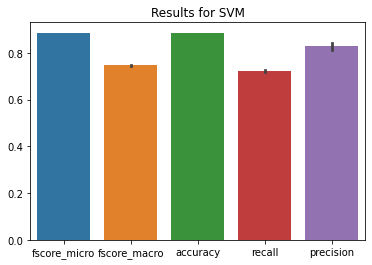

In [7]:
fig = sns.barplot(data=df_results)
fig.set_title('Results for SVM')
fig.figure.savefig('images/SVM_metrics.png')

In [8]:
df_results.mean(axis=0)

fscore_micro    0.884047
fscore_macro    0.745882
accuracy        0.884047
recall          0.723854
precision       0.826962
dtype: float64

Classification report

In [9]:
print(f"Classification report for classifier {clf}:\n"
      f"{metrics.classification_report(y_test, y_pred)}\n")

Classification report for classifier SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.81      0.69      0.75        32
           1       0.94      0.83      0.88        60
           2       0.79      0.94      0.86       403
           3       0.91      0.92      0.91       286
           4       0.95      0.86      0.90       147
           5       0.90      0.74      0.81        38
           6       0.93      0.98      0.95       505
           7       0.70      0.28      0.40        25
           8       0.93      0.99      0.96       235
           9       0.00      0.00      0.00        65
          10       0.00      0.00      0.00        68
          11       0.88      0.50      0.64        28
         

c:\users\askib\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix

In [11]:
c_m = metrics.confusion_matrix(y_test, y_pred)

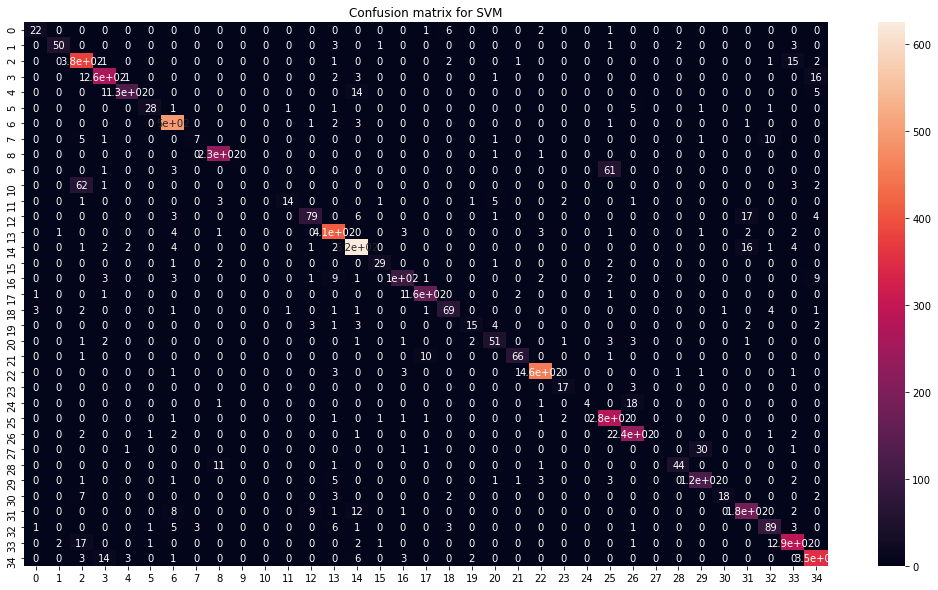

In [12]:
plt.figure(figsize=(18, 10))
fig = sns.heatmap(c_m, annot=True)
fig.set_title('Confusion matrix for SVM')
fig.figure.savefig('images/SVM_confusion_matrix.png')

Error analysis

In [47]:
def get_indices_wrong_predictions(y_true, y_pred, true_label):
    idxs_wrong = np.not_equal(y_true, y_pred).nonzero()[0]
    idxs_label = np.where(y_true == true_label)[0]
    idxs = np.intersect1d(idxs_wrong, idxs_label)
    return idxs
    
def plot_wrongly_predicted_from_class(X_test, y_true, y_pred, true_label, n_samples, shuffle=False):
    idxs = get_indices_wrong_predictions(y_true, y_pred, true_label)
    
    if shuffle:
        np.random.shuffle(idxs)
    idxs_filtered = idxs[:n_samples]
    
    X_filtered = X_test[idxs_filtered][:n_samples]
    # y_true_filtered = y_true[idxs_filtered][:n_samples]
    y_pred_filtered = y_pred[idxs_filtered][:n_samples]
    
    if len(X_filtered) < n_samples:
        n_samples = len(X_filtered)
        
    X_reshaped = np.reshape(X_filtered, (-1, 56, 56))
    
    fig, axes = plt.subplots(1, n_samples)
    fig.suptitle(f'Examples from class {true_label}')
    
    for i in range(n_samples):
        if n_samples == 1:
            axes.imshow(X_reshaped[i])
        else:
            axes[i].imshow(X_reshaped[i])
            axes[i].title.set_text(f'Predicted class {y_pred_filtered[i]}')        
    

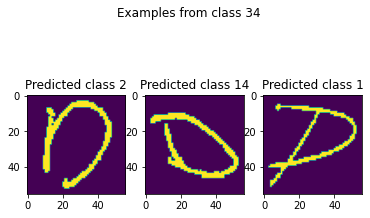

In [49]:
plot_wrongly_predicted_from_class(X_test, y_test, y_pred, true_label=34, n_samples=3)

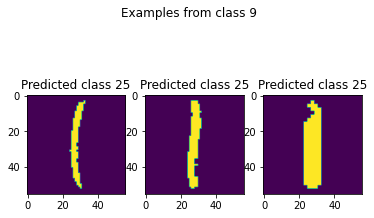

In [50]:
plot_wrongly_predicted_from_class(X_test, y_test, y_pred, true_label=9, n_samples=3, shuffle=True)

Note: The highest number of error is between true class 9 and predicted 25 - which are digit 1 and letter F respectively.
This is caused because in the dataset these classes have similar look and are indistinguishable by human eye.

In [ ]:
import joblib
_ = joblib.dump(clf, "models/svm.pkl")


In [ ]:
model = pickle.load(open(filename, 'rb'))

In [40]:
model = pickle.load(open(filename, 'rb'))

In [ ]:
model = pickle.load(open(filename, 'rb'))